# Measuring speed from CPU times per event
### Authors: Andrea Sciabà, Andrea Valassi

The goal is to measure the CPU power of sites from the CPU time per event of ATLAS production jobs.

In [1]:
import sys
import math
from collections import defaultdict, OrderedDict, Counter
import pprint as pp
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from __future__ import division

%matplotlib inline

First, let's read the data from the CSV file.

In [58]:
df = pd.read_csv('task_cpu_90d_1.csv', names=['jeditaskid', 'processingtype', 'transformation', 'atlrel', 'site',
                                                               'cputype', 'njobs', 'cpuevt_avg', 'cpuevt_rms', 'wallevt_avg',
                                                               'wallevt_rms', 'cpu', 'wc', 'cores', 'jevts', 'eff'])

Let's choose jobs of a given processing type by site or cpu.

In [59]:
event_type = 'evgen'
mode = 'cputype'

Let's find out which sites or CPU's contribute by more than 0.1% to the total wallclock time and restrict the analysis to them.

In [60]:
grouped = df[df.processingtype == event_type].groupby([mode], as_index=False)
tot_wc = grouped['wc'].sum()
a = tot_wc.sort_values('wc', ascending=False)
bigtotal_wc = a.wc.sum()
big_sites = a[a.wc > bigtotal_wc * 0.001][mode].tolist()

Let's store in a dict indexed by the task number and the site or CPU type the averages and standard deviations of the CPU time per event.

In [61]:
grouped = df.groupby(['processingtype', 'jeditaskid', mode], as_index=False, sort=False)

data = defaultdict(OrderedDict)
for (p, j, s), g in grouped:
    if s not in big_sites: continue
    if p != 'evgen': continue
    x = np.average(g.cpuevt_avg, weights=g.cpu)
    y = math.sqrt(np.average((g.cpuevt_avg - x)**2, weights=g.cpu))
    data[j][s] = (x, y)

Let's forget about tasks which run on only one site or CPU type.

In [62]:
# Remove from data tasks with only one site
for (k, v) in data.items():
    if len(v) == 1:
        del data[k]

Let's map sites or CPU types to integers and store the mapping for later use.

In [63]:
i = -1
sites = set()
smap = dict()
for (k, v) in data.items():
    for s in v.keys():
        if s not in sites:
            i += 1
            smap[s] = i
            sites.add(s)
        data[k][smap[s]]= data[k][s]
        del data[k][s]

nsites = len(smap)
print 'There are %s sites in the fit' % nsites

There are 67 sites in the fit


Let's also map tasks to integers.

In [64]:
# Map tasks to integers
tasks = set(data.keys())
tmap = dict()
i = 0
for x in tasks:
    tmap[x] = i
    i += 1

## First analysis

The following functions and gradients implement different attempts to fit the site or CPU speeds based on ratios between average CPU times per event. They are described here:
1. func, grad: for each task, ratios of CPU times per event at different sites are calculated in a rolling fashion (i + 1 value divided by i); only n - ratios are kept, as the n-th is redundant.
2. func2, grad2: as above, but all values are divided by the same value.
3. func3, grad3, as above, but inverting the ratios.
4. func4, grad4: as the first one, but with all the n ratios.

A constraint is defined by which one speed factor is defined to be 1. Bounds are defined to keep the speed factors in a reasonable range.

In [77]:
def func(k):
    total = 0.
    for _, task in data.items():   # looping on tasks
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([a[0] for a in task.values()])
        kf2 = np.roll(kf, -1)
        v2 = np.roll(v, -1)
        ratio = (v2 / v - kf / kf2)**2
        ratio[np.isnan(ratio)] = 0.
        ratio[np.isinf(ratio)] = 0.
        delta = np.sum(ratio[:-1])
        total += delta
    return total

In [78]:
def func2(k):
    total = 0.
    for _, task in data.items():
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([a[0] for a in task.values()])
        ratio = (v / v[0] - kf[0] / kf)**2
        ratio[np.isnan(ratio)] = 0.
        ratio[np.isinf(ratio)] = 0.
        delta = np.sum(ratio)
        total += delta
    return total

In [79]:
def func3(k):
    total = 0.
    for _, task in data.items():
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([a[0] for a in task.values()])
        ratio = (v[0] / v - kf / kf[0])**2
        ratio[np.isnan(ratio)] = 0.
        ratio[np.isinf(ratio)] = 0.
        delta = np.sum(ratio)
        total += delta
    return total

In [80]:
def func4(k):
    total = 0.
    for _, task in data.items():   # looping on tasks
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([a[0] for a in task.values()])
        kf2 = np.roll(kf, -1)
        v2 = np.roll(v, -1)
        ratio = (v2 / v - kf / kf2)**2
        ratio[np.isnan(ratio)] = 0.
        ratio[np.isinf(ratio)] = 0.
        delta = np.sum(ratio)
        total += delta
    return total

In [81]:
def grad(k):
    grad = np.zeros(len(k))
    for _, task in data.items():
        ns = np.array(task.keys())
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([a[0] for a in task.values()])
        for i in range(len(task)):
            if i == len(task) - 1:
                x1 = 0.
            else:
                x1 = -2 * (v[i+1] / v[i] - kf[i] / kf[i+1]) / kf[i+1]
            if np.isnan(x1) or np.isinf(x1): x1 = 0.
            if i == 0:
                x2 = 0.
            else:
                x2 = 2 * (v[i] / v[i-1] - kf[i-1] / kf[i]) * kf[i-1] / kf[i]**2
            if np.isnan(x2) or np.isinf(x2): x2 = 0.
            grad[ns[i]] += (x1 + x2)
    return grad

In [82]:
def grad2(k):
    grad = np.zeros(len(k))
    for _, task in data.items():
        ns = np.array(task.keys())
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([a[0] for a in task.values()])
        for i in range(len(task)):
            x = 0.
            if i == 0:
                for j in range(len(task)):
                    x += -2. * (v[j] / v[0] - k[0] / k[j]) / k[j]
            else:
                x = 2. * (v[i] / v[0] - k[0] / k[i]) * k[0] / k[i]**2
            grad[ns[i]] += x
    return grad

In [83]:
def grad3(k):
    grad = np.zeros(len(k))
    for _, task in data.items():
        ns = np.array(task.keys())
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([a[0] for a in task.values()])
        for i in range(len(task)):
            x = 0.
            if i == 0:
                for j in range(len(task)):
                    x += 2. * (v[0] / v[j] - k[j] / k[0]) * k[j] / k[0]**2
            else:
                x = -2. * (v[0] / v[i] - k[i] / k[0]) / k[0]
            grad[ns[i]] += x
    return grad

In [84]:
def grad4(k):
    grad = np.zeros(len(k))
    for _, task in data.items():
        ns = np.array(task.keys())
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([a[0] for a in task.values()])
        for i in range(len(task)):
            if i == len(task) - 1:
                x1 = -2 * (v[0] / v[i] - kf[i] / kf[0]) / kf[0]
            else:
                x1 = -2 * (v[i+1] / v[i] - kf[i] / kf[i+1]) / kf[i+1]
            if np.isnan(x1) or np.isinf(x1): x1 = 0.
            if i == 0:
                x2 = 2 * (v[i] / v[len(task)-1] - kf[len(task)-1] / kf[i]) * kf[len(task)-1] / kf[i]**2
            else:
                x2 = 2 * (v[i] / v[i-1] - kf[i-1] / kf[i]) * kf[i-1] / kf[i]**2
            if np.isnan(x2) or np.isinf(x2): x2 = 0.
            grad[ns[i]] += (x1 + x2)
    return grad

Let's define the initial values to be all one.

In [85]:
k_ini = np.ones(nsites)   # Initialises CPU factors for all sites to one

In [86]:
print 'Initial function value: ', func(k_ini)
print 'Initial function value: ', func2(k_ini)
print 'Initial function value: ', func3(k_ini)
print 'Initial function value: ', func4(k_ini)

Initial function value:  5154.37216086
Initial function value:  4949.56682413
Initial function value:  1793.25325587
Initial function value:  5349.19643092


Let's check that all the gradients are correctly calculated.

In [87]:
check = optimize.check_grad(func, grad, k_ini)
print check

0.00281052252407


In [20]:
check = optimize.check_grad(func2, grad2, k_ini)
print check

0.0975198126365


In [21]:
check = optimize.check_grad(func3, grad3, k_ini)
print check

0.0618822212822


In [22]:
check = optimize.check_grad(func4, grad4, k_ini)
print check

0.198448695626


This is the constraint.

In [88]:
site_ref = big_sites[0]
ref = smap[site_ref]
cons = ({'type': 'eq', 'fun': lambda x: x[ref] - 1})
bounds = [(0.5, 2.)] * len(k_ini)

The following cells run the minimisation.

In [89]:
result = optimize.minimize(func, k_ini, method='SLSQP', jac=grad, constraints=cons, bounds=bounds, options={'disp': True, 'maxiter': 2000})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3382.80965312
            Iterations: 87
            Function evaluations: 248
            Gradient evaluations: 87


In [90]:
k = result.x

In [91]:
print k

[ 0.9203111   0.84787795  0.90375182  0.96475665  1.05263306  0.98830302
  1.          1.07483017  0.93268     1.1109311   1.10157965  0.92220944
  0.59048561  1.31102362  0.77034372  0.79725756  0.74869468  0.69275004
  0.7897526   1.0609596   1.22616933  0.62768674  0.71428853  0.86029521
  0.97223051  1.13663884  0.79613653  0.76187262  0.96099788  0.82633806
  0.7103207   0.70353702  0.86962827  0.99706122  0.95598943  0.97002948
  0.8824965   0.67218032  0.98717287  0.83768641  1.05165085  0.99984615
  0.71820131  0.61748217  0.67306723  1.21817819  0.66231596  1.16161147
  1.05044254  0.74549837  0.74571075  0.64950206  0.77190214  1.11049898
  0.69692935  0.89119272  0.86381654  1.23741229  1.21839936  0.72409618
  0.94655266  0.54372924  1.18399193  1.18438008  1.00371187  0.94041475
  0.58076799]


In [31]:
for s in sorted(smap.keys()):
    print '%s\t%f' % (s, k[smap[s]])

s+AMD Opteron(TM) Processor 6212                  2048 KB	0.749338
s+AMD Opteron(TM) Processor 6220                  2048 KB	0.814800
s+AMD Opteron(TM) Processor 6234                  2048 KB	0.675419
s+AMD Opteron(TM) Processor 6238                  2048 KB	0.781330
s+AMD Opteron(TM) Processor 6272 2048 KB	0.654642
s+AMD Opteron(TM) Processor 6274                  2048 KB	0.670177
s+AMD Opteron(TM) Processor 6274 2048 KB	0.709875
s+AMD Opteron(TM) Processor 6276                  2048 KB	0.639983
s+AMD Opteron(TM) Processor 6276                  512 KB	0.622113
s+AMD Opteron(TM) Processor 6276 2048 KB	0.635178
s+AMD Opteron(tm) Processor 6134 512 KB	0.857238
s+AMD Opteron(tm) Processor 6168 512 KB	0.699105
s+AMD Opteron(tm) Processor 6320                  2048 KB	0.945402
s+AMD Opteron(tm) Processor 6376                  2048 KB	0.746602
s+AMD Opteron(tm) Processor 6378                  2048 KB	0.794811
s+AMD Opteron(tm) Processor 6378 2048 KB	0.812217
s+Dual-Core AMD Opteron(tm) Proce

In [32]:
result2 = optimize.minimize(func2, k_ini, method='SLSQP', jac=grad2, constraints=cons, options={'disp': True, 'maxiter': 2000})

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3286356995.01
            Iterations: 8
            Function evaluations: 72
            Gradient evaluations: 8


In [33]:
k2 = result2.x

In [34]:
result3 = optimize.minimize(func3, k_ini, method='SLSQP', jac=grad3, constraints=cons, bounds=bounds, options={'disp': True, 'maxiter': 2000})

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 35632.3926444
            Iterations: 49
            Function evaluations: 459
            Gradient evaluations: 45


In [35]:
k3 = result3.x

In [36]:
result4 = optimize.minimize(func4, k_ini, method='SLSQP', jac=grad4, constraints=cons, bounds=bounds, options={'disp': True, 'maxiter': 2000})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 108598.967643
            Iterations: 111
            Function evaluations: 337
            Gradient evaluations: 111


In [37]:
k4 = result4.x

The conclusion of this preliminary study is that the rolling ratios functions (1. and 4.) converge, while the other functions do not. Using a single site of CPU type as a reference for all the others in a task seems to create instability, which is vaguely intuitive, considering that if the CPU time per event is badly measured for it, it will make all the ratios to be wrong. This "asymmetry of roles" is not present in the rolling ratios functions, which turn out to be well behaved.

## Second analysis

This analysis uses a much better model and procedure to fit the speeds.

In the following, $\alpha$ indicates an index running over tasks and $i$ and index running over sites or CPU times.
The population average of the CPU time per event for task $\alpha$ at site or CPU $i$ is $\mu_{i\alpha}$ and the average we measure is $a_{i\alpha}$. Of course, not all sites or CPU types appear on all tasks, so sums over $i$ run only on sites or CPU types where the task runs.

It is assumed that the $a_{i\alpha}$ values we measure are Gaussian-distributed around $\mu_{i\alpha}$ with standard deviation $\sigma_{i\alpha}$.

It is also assumed that the speed factors $k_i$ do not depend on $\alpha$, and in particular that $\mu_{i\alpha}k_i=A_\alpha$, where $A_\alpha$ is a constant with respect to $i$.

It is assumed that also $\sigma_{i\alpha}=S_\alpha\mu_{i\alpha},\:\forall i, \alpha$.

To make the analysis easier, we choose to use $\sigma_{i\alpha}$ as errors on $a_{i\alpha}$, while it would be more correct to use $\sigma_{i\alpha}/\sqrt{N_{i\alpha}}$, where $N_{i\alpha}$ is the number of jobs run at site or CPU type $i$ for task $\alpha$ (_approx. #1_).

We also assume that $S_\alpha = S$, where $S$ is constant for all tasks (_approx. #2_).

The $\chi^2$ we want to minimise is the following:

$$\chi^2=\sum_{i\alpha}\left(\frac{a_{i\alpha}-\mu_{i\alpha}}{\sigma_{i\alpha}}\right)^2=\sum_{i\alpha}\left(\frac{a_{i\alpha}-\mu_{i\alpha}}{S_\alpha\mu_{i\alpha}}\right)^2=\sum_\alpha\frac{1}{S_\alpha^2}\sum_i\left(\frac{a_{i\alpha}}{\mu_{i\alpha}}-1\right)^2=\sum_\alpha\frac{1}{S_\alpha^2}\sum_i\left(\frac{a_{i\alpha}k_i}{A_\alpha}-1\right)^2$$

finally, taking into account the approximations above:

$$\boxed{\chi^2=\frac{1}{S^2}\sum_\alpha\frac{1}{A_\alpha^2}\sum_i\left(a_{i\alpha}k_i-A_\alpha\right)^2}$$

As $S$ is a constant, we can minimise a function $f=S^2\chi^2$ and the free parameters are $A_\alpha$ and $k_i$.

To recap, the function to minimise is

$$f=\sum_\alpha\frac{1}{A_\alpha^2}\sum_i\left(a_{i\alpha}k_i-A_\alpha\right)^2$$

its gradient is

$$\begin{align}\frac{\partial f}{\partial A_\alpha}&=-2\sum_i\frac{a_{i\alpha}k_i}{A_\alpha^2}\left(\frac{a_{i\alpha}k_i}{A_\alpha}-1\right)\\\frac{\partial f}{\partial k_i}&=\sum_\alpha\frac{1}{A_\alpha^2}2a_{i\alpha}(a_{i\alpha}k_i-A_\alpha)\end{align}$$

and its Hessian is

$$\begin{align}\frac{\partial^2f}{\partial A_\alpha\partial A_\beta}&=\delta_{\alpha\beta}\times\frac{2}{A_\alpha^4}\sum_i(3a_{i\alpha}^2k_i^2-2a_{i\alpha}k_i A_\alpha)\\
\frac{\partial^2f}{\partial k_i\partial k_j}&=\delta_{ij}\times 2\sum_\alpha\frac{a_{i\alpha}^2}{A_\alpha^2}\\
\frac{\partial^2f}{\partial k_i\partial A_\alpha}&=-2\frac{a_{i\alpha}}{A_\alpha^2}\left(2\frac{a_{i\alpha}k_i}{A_\alpha}-1\right)
\end{align}$$

We use as initial values $k_i=1$ and $A_\alpha=(\sum_i a_{i\alpha})/n_\alpha$, where $n_\alpha$ is the number of sites or CPU types in task $\alpha$.

In [65]:
ntask = len(data)
nsite = len(smap)
a_ini = np.zeros(ntask)
for j, task in data.items():
    nt = tmap[j]
    a_ini[nt] = np.mean([b[0] for b in task.values()])
x_ini = np.hstack((a_ini, np.ones(nsite)))

In [105]:
print "Tasks: ", ntask
print "Sites/CPUs: ", nsite
print "Sum of initial values: ", np.sum(x_ini)

 Tasks:  2099
Sites/CPUs:  67
Sum of initial values:  109154.684952


The function and its derivatives are implemented.

In [66]:
def func_val(x):
    a = x[:ntask]
    k = x[ntask:]
    total = 0.
    for j, task in data.items():   # looping on tasks
        nt = tmap[j]
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([b[0] for b in task.values()])
        f_term = 1. / a[nt]**2 * (v * kf - a[nt])**2
        delta = np.sum(f_term)
        total += delta
    return total

In [67]:
def grad_val(x):
    a = x[:ntask]
    k = x[ntask:]
    g = np.zeros(len(x))
    for j, task in data.items():
        g_a = 0.
        nt = tmap[j]
        for i in task.keys():
            (v, _) = task[i]
            g_a += -2 * v * k[i] / a[nt]**2 * (v * k[i] / a[nt] - 1)
            g_k = 2 / a[nt]**2 * v * (k[i] * v - a[nt])
            g[ntask + i] += g_k
        g[nt] = g_a
    return g

In [68]:
def hess_val(x):
    a = x[:ntask]
    k = x[ntask:]
    diag = np.zeros_like(x)   # diagonal of the Hessian
    H = np.diag(diag)
    for t, task in data.items():
        h = 0.
        nt = tmap[t]
        for i in task.keys():
            (v, _) = task[i]
            h += 2 / a[nt]**4 * (3 * v**2 * k[i]**2 - 2 * v * k[i] * a[nt])
            diag[ntask + i] += 2 * v**2 / a[nt]**2
            H[nt][ntask+i] = H[ntask+i][nt] = -2 * v / a[nt]**2 * ( 2 * v * k[i] / a[nt] - 1)
        diag[nt] = h
    H = H + np.diag(diag)
    return H

In [69]:
func_val(x_ini)

1261.9081937161777

In [70]:
check = optimize.check_grad(func_val, grad_val, x_ini)
print check

0.0214708002556


The minimisation is performed.

In [71]:
result_val = optimize.minimize(func_val, x_ini, method='Newton-CG', jac=grad_val, hess=hess_val, options={'disp': True, 'maxiter': 2000})

Optimization terminated successfully.
         Current function value: 456.335094
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 54
         Hessian evaluations: 27


It is worth noting that the problem is underdetermined: multiplying all $k_i$ and all $A_\alpha$ by the same number would not change the value of the function. Hence, the absolute scale of the fitted parameters has no meaning (as expected), and they should be rescaled to an appropriate reference. In principle, the fit should not converge, but it does. A more rigorous approach would be to fix one of the $k_i$ parameters to one and reduce by one the number of parameters fitted. This is left as a future improvement.

The fitted parameters are printed:

In [72]:
k_val = result_val.x[ntask:]

In [73]:
print k_val

[ 1.06718131  0.96453373  0.99156144  1.0478772   1.10285937  1.08086861
  1.04768215  1.17705344  1.02122293  1.19392752  1.23487107  1.05946841
  0.66819168  1.3654004   0.87034613  0.90802905  0.86045232  0.79052688
  0.8996339   1.17018201  1.33271974  0.69916389  0.80586691  0.97878962
  1.0688484   1.22933889  0.89317876  0.85665689  1.04956099  0.94614094
  0.78399002  0.86587867  1.01287507  1.11874467  1.04659525  1.1044643
  1.02093972  0.78009428  1.11285243  0.91079653  1.23376482  1.17117169
  0.81758881  0.70651407  0.75085708  1.3537007   0.75238521  1.285113
  1.16069546  0.89523367  0.89919494  0.7762106   0.8464897   1.26500103
  0.77877544  0.96973559  1.01768231  1.41734695  1.32679151  0.8457124
  1.05941606  0.65339001  1.27333     1.27410874  1.14224729  1.11076906
  0.79106846]


As a check, the values fitted with this method are compared with the values fitted with the rolling ratios method.

In [92]:
k_sci = k

<Container object of 3 artists>

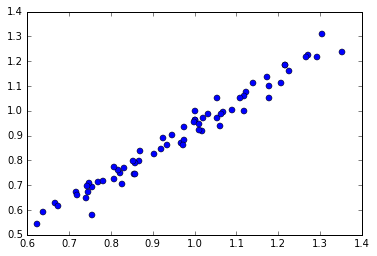

In [93]:
plt.errorbar(k_val / k_val[smap[site_ref]], k, fmt='o')

### Error estimation

In order to estimate the error on the fitted parameters, we can use the standard method of finding the variations on the parameters that increase the value of $\chi^2$ by one with respect to its minimum. To do this, we must calculate the value of $S$.

From what was said above:

$$S=\frac{\sigma_{i\alpha}k_i}{A_\alpha}$$

and considering that $\sigma_{i\alpha}$ is the standard deviation of $a_{i\alpha}$, we can expect that the observed values $\frac{a_{i\alpha}k_i}{A_\alpha}$ will be distributed around one with a standard deviation of $S$.

Around the minimum, the following equation holds:

$$1\equiv\chi^2-\chi^2_{\text{min}}=\frac{\Delta f}{S^2}\simeq\frac{1}{S^2}\frac{1}{2}\frac{\partial^2f}{\partial k_i^2}\Delta k_i^2$$

and considering that

$$\frac{\partial^2f}{\partial k_i^2}=2\sum_\alpha\frac{a_{i\alpha}^2}{A_\alpha^2}$$

one concludes that

$$\Delta k_i\simeq\frac{S}{\sqrt{\sum_\alpha\frac{a_{i\alpha}^2}{A_\alpha^2}}}$$

We can easily measure $S$ from the data as follows.

In [94]:
x = result_val.x
points = list()
for t, task in data.items():
    nt = tmap[t]
    for i in task.keys():
        (v, _) = task[i]
        p = v * x[ntask+i] / x[nt]
        points.append(p)

The value of S is: 0.139


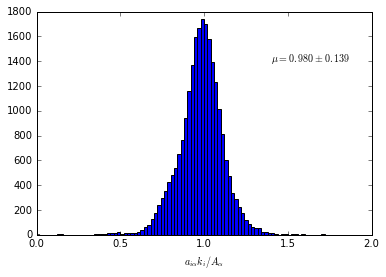

In [108]:
bins = 100
xrange = (0., 2.)
binsize = (xrange[1] - xrange[0]) / bins
fig = plt.hist(points, bins=bins, range=xrange)
n = len(points)
mu = np.mean(points)
sigma = np.std(points)
plt.xlabel(r'$a_{i\alpha}k_i/A_\alpha$')
plt.text(1.4, 1400., r'$\mu=%.3f\pm%.3f$' % (mu, sigma))
S = sigma
print 'The value of S is: %.3f' % S

For fun, let's fit the distribution with one gaussian.

In [96]:
y, x = np.histogram(points, bins=bins, range=xrange)
y = np.divide(y, np.float(np.sum(y))*binsize)

0.978105028158 0.111407322451
The value of S is: 0.111


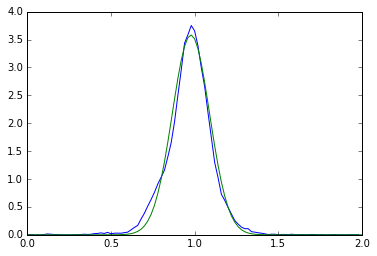

In [97]:
def f(x, m, s):
    return 1 / (s * np.sqrt(2 * np.pi)) * np.exp(-(x - m)**2 / (2 * s**2))

plt.plot(x[:-1], y)
(m, s), _ = optimize.curve_fit(f, x[:-1], y)
print m, s
plt.plot(x, f(x, m, s))
S1 = s
print 'The value of S is: %.3f' % S1

And now, with two gaussians.

0.97926849027 0.0696830777701 0.149028050994 0.35288405799
The value of S is: 0.127


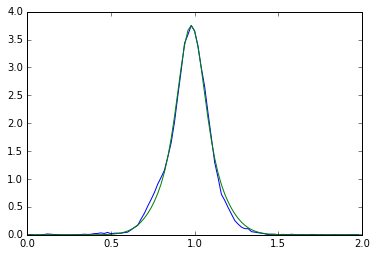

In [98]:
def f2(x, m, s1, s2, n):
    return n / (s1 * np.sqrt(2 * np.pi)) * np.exp(-(x - m)**2 / (2 * s1**2)) + \
        (1 - n) / (s2 * np.sqrt(2 * np.pi)) * np.exp(-(x - m)**2 / (2 * s2**2))
 
plt.plot(x[:-1], y)
(m, s1, s2, n), _ = optimize.curve_fit(f2, x[:-1], y, (1., 0.1, 1., 1.))
print m, s1, s2, n
plt.plot(x, f2(x, m, s1, s2, n))
S2 = np.sqrt(n * s1**2 + (1 - n) * s2**2)
print 'The value of S is: %.3f' % S2

The fit to two gaussians is remarkably good.

In [99]:
x = result_val.x
points2 = list()
for t, task in data.items():
    nt = tmap[t]
    for i in task.keys():
        (v, _) = task[i]
        p = v / a_ini[nt]
        points2.append(p)

The value of S is: 0.233


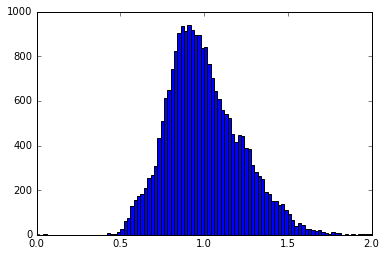

In [100]:
bins = 100
xrange = (0., 2.)
binsize = (xrange[1] - xrange[0]) / bins
fig = plt.hist(points2, bins=bins, range=xrange)
n = len(points2)
mu = np.mean(points2)
sigma = np.std(points2)
print 'The value of S is: %.3f' % sigma

In [101]:
x = result_val.x
a = x[:ntask]
k = x[ntask:]
k_err = np.zeros_like(k)
c = 0
for t, task in data.items():
    nt = tmap[t]
    c += len(task)
    for i in task.keys():
        (v, _) = task[i]
        k_err[i] += v**2 / a[nt]**2
k_err = S / np.sqrt(k_err)

### Goodness of fit

To test the goodness of our fit, we can calculate the reduced $\chi^2$ ad the minimum, which is $\chi^2/(N-m)$, where $N$ is the number of independent measurements and $m$ the number of fitted parameters.

In [112]:
deg = c - len(x_ini)
chi2r = func_val(result_val.x) / S**2 / deg
print 'Degrees of freedom: %d' % deg
print 'The value of the reduced chi2 is: %.3f' % chi2r
print 'Standard deviation of reduced chi2: %.3f' % (1. / np.sqrt(2. * deg))

Degrees of freedom: 21101
The value of the reduced chi2 is: 1.125
Standard deviation of reduced chi2: 0.005
